# Sports Articles Predictive Classifier

Dataset has been obtained from [BBC Sports Dataset](http://mlg.ucd.ie/datasets/bbc.html)

Through this corpus, we will try to predict which category/sport a particular sports article belongs.

In [45]:
%matplotlib inline

import os
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd
import re

from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

### Data Processing

Process all the text articles related to different categories
* bbcsport/
    - athletics/
    - cricket/
    - football/
    - tennis/
    - rugby/

In [46]:
all_lines = defaultdict(list)
rootdir = './bbcsport/'

# read in all the files
for subdir, dirs, files in os.walk(rootdir):
    for file_ in files:
        with open(os.path.join(subdir, file_), 'r') as f:
            article_category = subdir.split('/')[-1]
            curr_lines = f.readlines()
            all_lines[article_category].append(curr_lines)

# cleanup articles
for article_category, related_articles in all_lines.iteritems():
    for i in range(len(related_articles)):
        related_articles[i] = filter(
            None,
            [sentence.strip() for sentence in related_articles[i]]
        )
    all_lines[article_category] = related_articles

# create data strcture to eventually pass into a df
article_category_mapping = defaultdict(str)
for article_category, related_articles in all_lines.iteritems():
    for i in range(len(related_articles)):
        for lines in related_articles[i]:
            article_category_mapping[lines] = article_category


### Cleanup and Conversion

* Remove unwanted special characters
* Remove words containing numbers
* Map the categories to numerical labels for analysis

In [47]:
# create the df using the pre populated dict
article_category_df = pd.DataFrame(article_category_mapping.items(), columns=['line', 'category'])

# remove special characters from the lines
article_category_df['line'] = [
    re.sub('[^A-Za-z0-9]+', ' ', line)
    for line in article_category_df['line']
]

# remove all words containing digits. these words would add noise.
article_category_df['line'] = [
    ' '.join(s for s in line.split() if not any(c.isdigit() for c in s))
    for line in article_category_df['line']
]


# map category to ints
article_category_df['category_label'] = article_category_df.category.map({
    'athletics': 0,
    'cricket': 1,
    'tennis': 2,
    'rugby': 3,
    'football': 4,
})

### Train + Test Sets

In [48]:
# break down into data and labels
X = article_category_df.line
y = article_category_df.category_label

# train set and test set...
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [49]:
print ("X_train shape: " + str(X_train.shape))
print ("X_test shape: " + str(X_test.shape))

X_train shape: (2925,)
X_test shape: (975,)


### CountVectorizer

The goal here is to make a [document term matrix](https://en.wikipedia.org/wiki/Document-term_matrix) from the training and test sets. 

In [50]:
vect = CountVectorizer(stop_words='english')

vect.fit(X_train)

# convert the train and test set to a doc term matrix
X_train_dtm = vect.transform(X_train)
X_test_dtm = vect.transform(X_test)

In [51]:
X_train_dtm

<2925x11093 sparse matrix of type '<type 'numpy.int64'>'
	with 79435 stored elements in Compressed Sparse Row format>

In [52]:
X_test_dtm

<975x11093 sparse matrix of type '<type 'numpy.int64'>'
	with 24623 stored elements in Compressed Sparse Row format>

### KDE


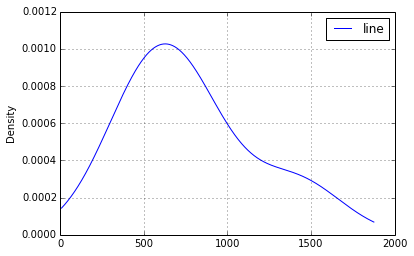

In [53]:
article_category_df[['category_label', 'line']].groupby('category_label').count().plot(kind='kde')
plt.show()

Seems like a fair enough distribution for the given number of classes (Sports Articles Categories). This should result in a viable accuracy.

### Multinomial Naive Bayes

Looking at the dataset
* It has multivalued and discrete labels for the sets
* Frequency might be a better indicator than simple occurence (whether or not a term is present in a document)

Thus, we will use [Multinomial Naive Bayes](https://en.wikipedia.org/wiki/Naive_Bayes_classifier#Multinomial_naive_Bayes).

In [54]:
nb = MultinomialNB()

nb.fit(X_train_dtm, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [55]:
y_pred_class = nb.predict(X_test_dtm)

### Prediction Results

In [56]:
accuracy_score(y_test, y_pred_class)

0.96410256410256412

In [57]:
print (classification_report(y_test, y_pred_class))

             precision    recall  f1-score   support

          0       0.98      0.95      0.97       127
          1       0.98      0.94      0.96       189
          2       0.99      0.94      0.97       119
          3       0.93      0.99      0.96       184
          4       0.96      0.98      0.97       356

avg / total       0.97      0.96      0.96       975



In [58]:
confusion_matrix(y_test, y_pred_class)

array([[121,   0,   0,   2,   4],
       [  0, 177,   1,   5,   6],
       [  1,   0, 112,   3,   3],
       [  0,   0,   0, 182,   2],
       [  1,   3,   0,   4, 348]])

In [59]:
# check the predicted labels for test lines
pred_df = pd.DataFrame()

pred_df['line'] = X_test
pred_df['label'] = y_pred_class

# re-map the labels
pred_df['label'] = pred_df.label.map({
    4: 'football',
    3: 'rugby',
    2: 'tennis',
    1: 'cricket',
    0: 'athletics'  
})

In [60]:
pred_df.head()

,line,label
0,The American spent three days at the LTA s ann...,tennis
1,Morton Moffat MacRae Hore Berthinussen Warnock...,rugby
2,Pakistan slump in debut,cricket
3,Kostas Kenteris and Katerina Thanou are yet to...,athletics
4,Cudicini misses Carling Cup final,football
